In [10]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

Read the dataset:

In [2]:
tweets = pd.read_csv('./Dataset/Tweets.csv', sep=',')

Showing some dataset rows

In [3]:
tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


Select only interestig fields:

In [4]:
data = tweets[['text','airline_sentiment']]

Clean up the dataset, conidering only positive and negative tweets:

In [5]:
data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)

4726
18356


Tokenization:

In [8]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

## Neural network:


In [52]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 128)           256000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


declaring dataset

In [12]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7732, 32) (7732, 2)
(3809, 32) (3809, 2)


Selecting some data for training and some for validation

In [29]:
X_val = X_train[:500]
Y_val = Y_train[:500]

In [30]:
partial_X_train = X_train[500:]
partial_Y_train = Y_train[500:]

## Train the network:

In [53]:
batch_size = 512
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

Train on 7232 samples, validate on 500 samples
Epoch 1/10
7232/7232 [==============================] - 21s 3ms/step - loss: 0.5730 - acc: 0.7688 - val_loss: 0.4338 - val_acc: 0.7960
Epoch 2/10
7232/7232 [==============================] - 20s 3ms/step - loss: 0.4080 - acc: 0.8191 - val_loss: 0.3696 - val_acc: 0.8340
Epoch 3/10
7232/7232 [==============================] - 21s 3ms/step - loss: 0.3306 - acc: 0.8550 - val_loss: 0.2776 - val_acc: 0.8800
Epoch 4/10
7232/7232 [==============================] - 20s 3ms/step - loss: 0.2467 - acc: 0.8993 - val_loss: 0.2147 - val_acc: 0.9140
Epoch 5/10
7232/7232 [==============================] - 20s 3ms/step - loss: 0.1885 - acc: 0.9266 - val_loss: 0.1954 - val_acc: 0.9300
Epoch 6/10
7232/7232 [==============================] - 20s 3ms/step - loss: 0.1549 - acc: 0.9382 - val_loss: 0.1780 - val_acc: 0.9380
Epoch 7/10
7232/7232 [==============================] - 20s 3ms/step - loss: 0.1410 - acc: 0.9484 - val_loss: 0.1842 - val_acc: 0.9380
Epoch 8/

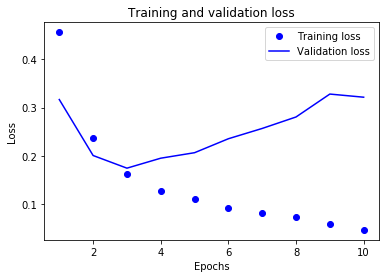

In [48]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

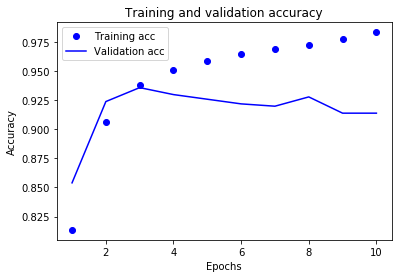

In [49]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Validation

In [51]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 78.26086956521739 %
neg_acc 94.44444444444444 %
